In [ ]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
#Loading the dataset
data = pd.read_csv("/content/marketing_campaign.csv", sep="\t")
print("Number of records:", len(data))
data.tail()

Number of records: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
2235  10870        1967  Graduation        Married  61223.0        0   
2236   4001        1946         PhD       Together  64014.0        2   
2237   7270        1981  Graduation       Divorced  56981.0        0   
2238   8235        1956      Master       Together  69245.0        0   
2239   9405        1954         PhD        Married  52869.0        1   

      Teenhome Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  \
2235         1  13-06-2013       46       709  ...                  5   
2236         1  10-06-2014       56       406  ...                  7   
2237         0  25-01-2014       91       908  ...                  6   
2238         1  24-01-2014        8       428  ...                  3   
2239         1  15-10-2012       40        84  ...                  7   

      AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
2235             0             0             0             0             0   
2236             0             0             0             1             0   
2237             0             1             0             0             0   
2238             0             0             0             0             0   
2239             0             0             0             0             0   

      Complain  Z_CostContact  Z_Revenue  Response  
2235         0              3         11         0  
2236         0              3         11         0  
2237         0              3         11         0  
2238         0              3         11         0  
2239         0              3         11         1  

[5 rows x 29 columns]

In [ ]:
#Information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

#Data Preprocessing

Feature engineering

Data cleaning

Label encoding

Data scaling/normalization

Dimension reduction

#Feature Engineering

engineer some new features:

"Age"  indicates the birth year of the respective person.

"Spent" indicates the total amount spent by the customer in various categories over the span of two years.

"Living_With" indicates the living situation of couples.

"Children" indicates total children in a household

"Family_Size" indicates total number of people living in the house

"Is_Parent" indicates parenthood status

simplyfy "Education" value counts.
Dropping some of the redundant features

"Customer_For" indicates the number of days the customers started to shop in the store relative to the last recorded date

In [ ]:
#Feature Engineering
#Age of customer in 2021
data["Age"] = 2021-data["Year_Birth"]

#Total spendings
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Total children in the house
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Total family members
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Rarenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Simplify education levels
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#rename product categories
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

#remove replaced features
fea_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(fea_drop, axis=1)

<ipython-input-29-0985482180ce>:26: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])


In [ ]:
data.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2240.000000  2240.000000  2240.000000  2240.000000   
mean    52247.251354     0.444196     0.506250    49.109375   303.935714   
std     25173.076661     0.538398     0.544538    28.962453   336.597393   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    23.750000   
50%     51381.500000     0.000000     0.000000    49.000000   173.500000   
75%     68522.000000     1.000000     1.000000    74.000000   504.250000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2240.000000  2240.000000  2240.000000  2240.000000  2240.000000  ...   
mean     26.302232   166.950000    37.525446    27.062946    44.021875  ...   
std      39.773434   225.715373    54.628979    41.280498    52.167439  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       1.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    67.000000    12.000000     8.000000    24.000000  ...   
75%      33.000000   232.000000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   263.000000   362.000000  ...   

       AcceptedCmp1  AcceptedCmp2     Complain     Response          Age  \
count   2240.000000   2240.000000  2240.000000  2240.000000  2240.000000   
mean       0.064286      0.013393     0.009375     0.149107    52.194196   
std        0.245316      0.114976     0.096391     0.356274    11.984069   
min        0.000000      0.000000     0.000000     0.000000    25.000000   
25%        0.000000      0.000000     0.000000     0.000000    44.000000   
50%        0.000000      0.000000     0.000000     0.000000    51.000000   
75%        0.000000      0.000000     0.000000     0.000000    62.000000   
max        1.000000      1.000000     1.000000     1.000000   128.000000   

             Spent     Children  Family_Size    Is_Parent  Customer_For  
count  2240.000000  2240.000000  2240.000000  2240.000000  2.240000e+03  
mean    605.798214     0.950446     2.595089     0.715179  4.424054e+16  
std     602.249288     0.751803     0.906959     0.451430  2.006466e+16  
min       5.000000     0.000000     1.000000     0.000000  0.000000e+00  
25%      68.750000     0.000000     2.000000     0.000000  2.944080e+16  
50%     396.000000     1.000000     3.000000     1.000000  4.432320e+16  
75%    1045.500000     1.000000     3.000000     1.000000  5.920560e+16  
max    2525.000000     3.000000     5.000000     1.000000  9.184320e+16  

[8 rows x 28 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2240 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2240 non-null   int64  
 3   Teenhome             2240 non-null   int64  
 4   Recency              2240 non-null   int64  
 5   Wines                2240 non-null   int64  
 6   Fruits               2240 non-null   int64  
 7   Meat                 2240 non-null   int64  
 8   Fish                 2240 non-null   int64  
 9   Sweets               2240 non-null   int64  
 10  Gold                 2240 non-null   int64  
 11  NumDealsPurchases    2240 non-null   int64  
 12  NumWebPurchases      2240 non-null   int64  
 13  NumCatalogPurchases  2240 non-null   int64  
 14  NumStorePurchases    2240 non-null   int64  
 15  NumWebVisitsMonth    2240 non-null   i

24 records have missing value, take approximately 1.07%, which is acceptable
these records can be eliminated during data processing.

#Data cleaning

handle missing values

handle outliers

Remove missing value

In [ ]:
#To remove the missing values
data = data.dropna()
print("The total number of data-points(records) after removing the rows with missing values are:", len(data))

The total number of data-points(records) after removing the rows with missing values are: 2216


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   Wines                2216 non-null   int64  
 6   Fruits               2216 non-null   int64  
 7   Meat                 2216 non-null   int64  
 8   Fish                 2216 non-null   int64  
 9   Sweets               2216 non-null   int64  
 10  Gold                 2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   i

detect outliers

<Figure size 800x550 with 0 Axes>

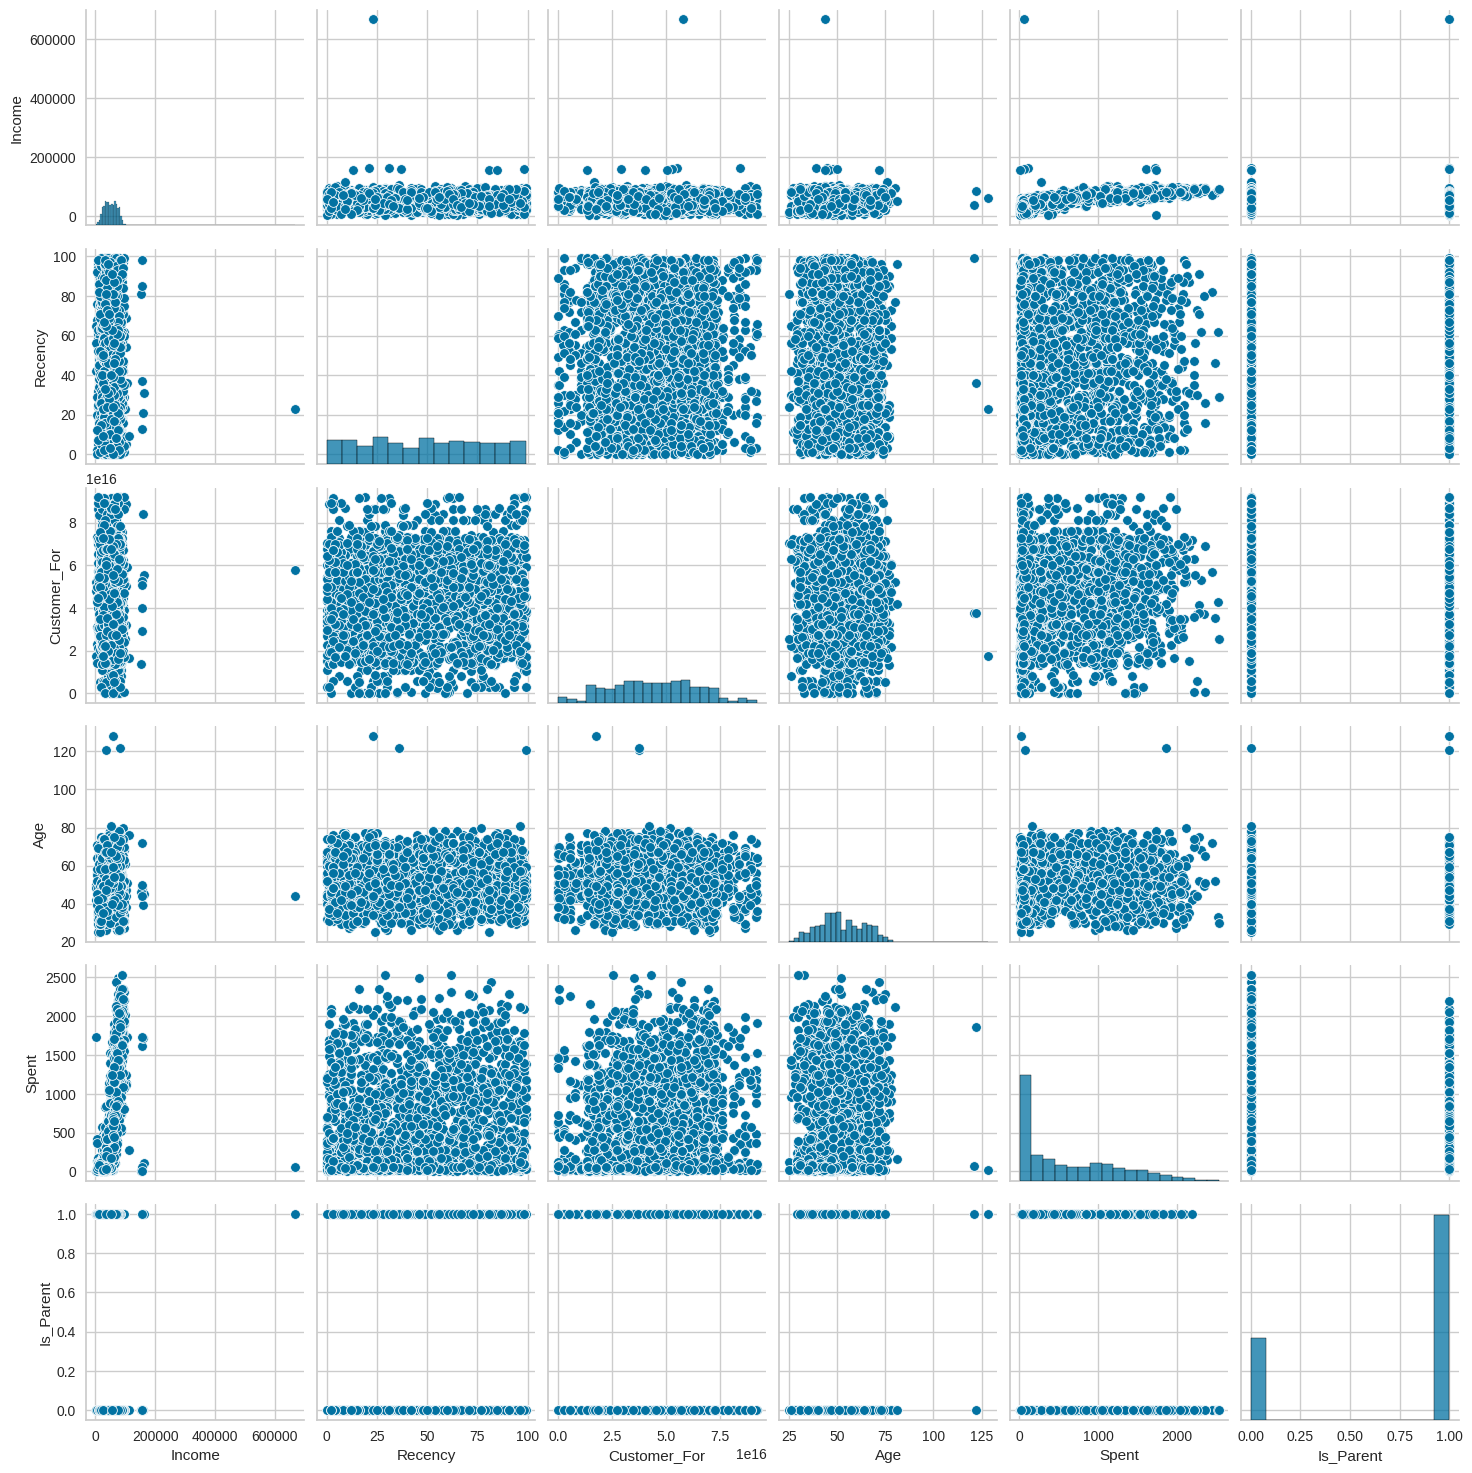

In [ ]:
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]

plt.figure()
sns.pairplot(data[To_Plot])

plt.show()

In [ ]:
#Dropping the outliers by setting a cap on Age and income.
data = data[(data["Age"]<90)]
data = data[(data["Income"]<113000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2204


<Figure size 800x550 with 0 Axes>

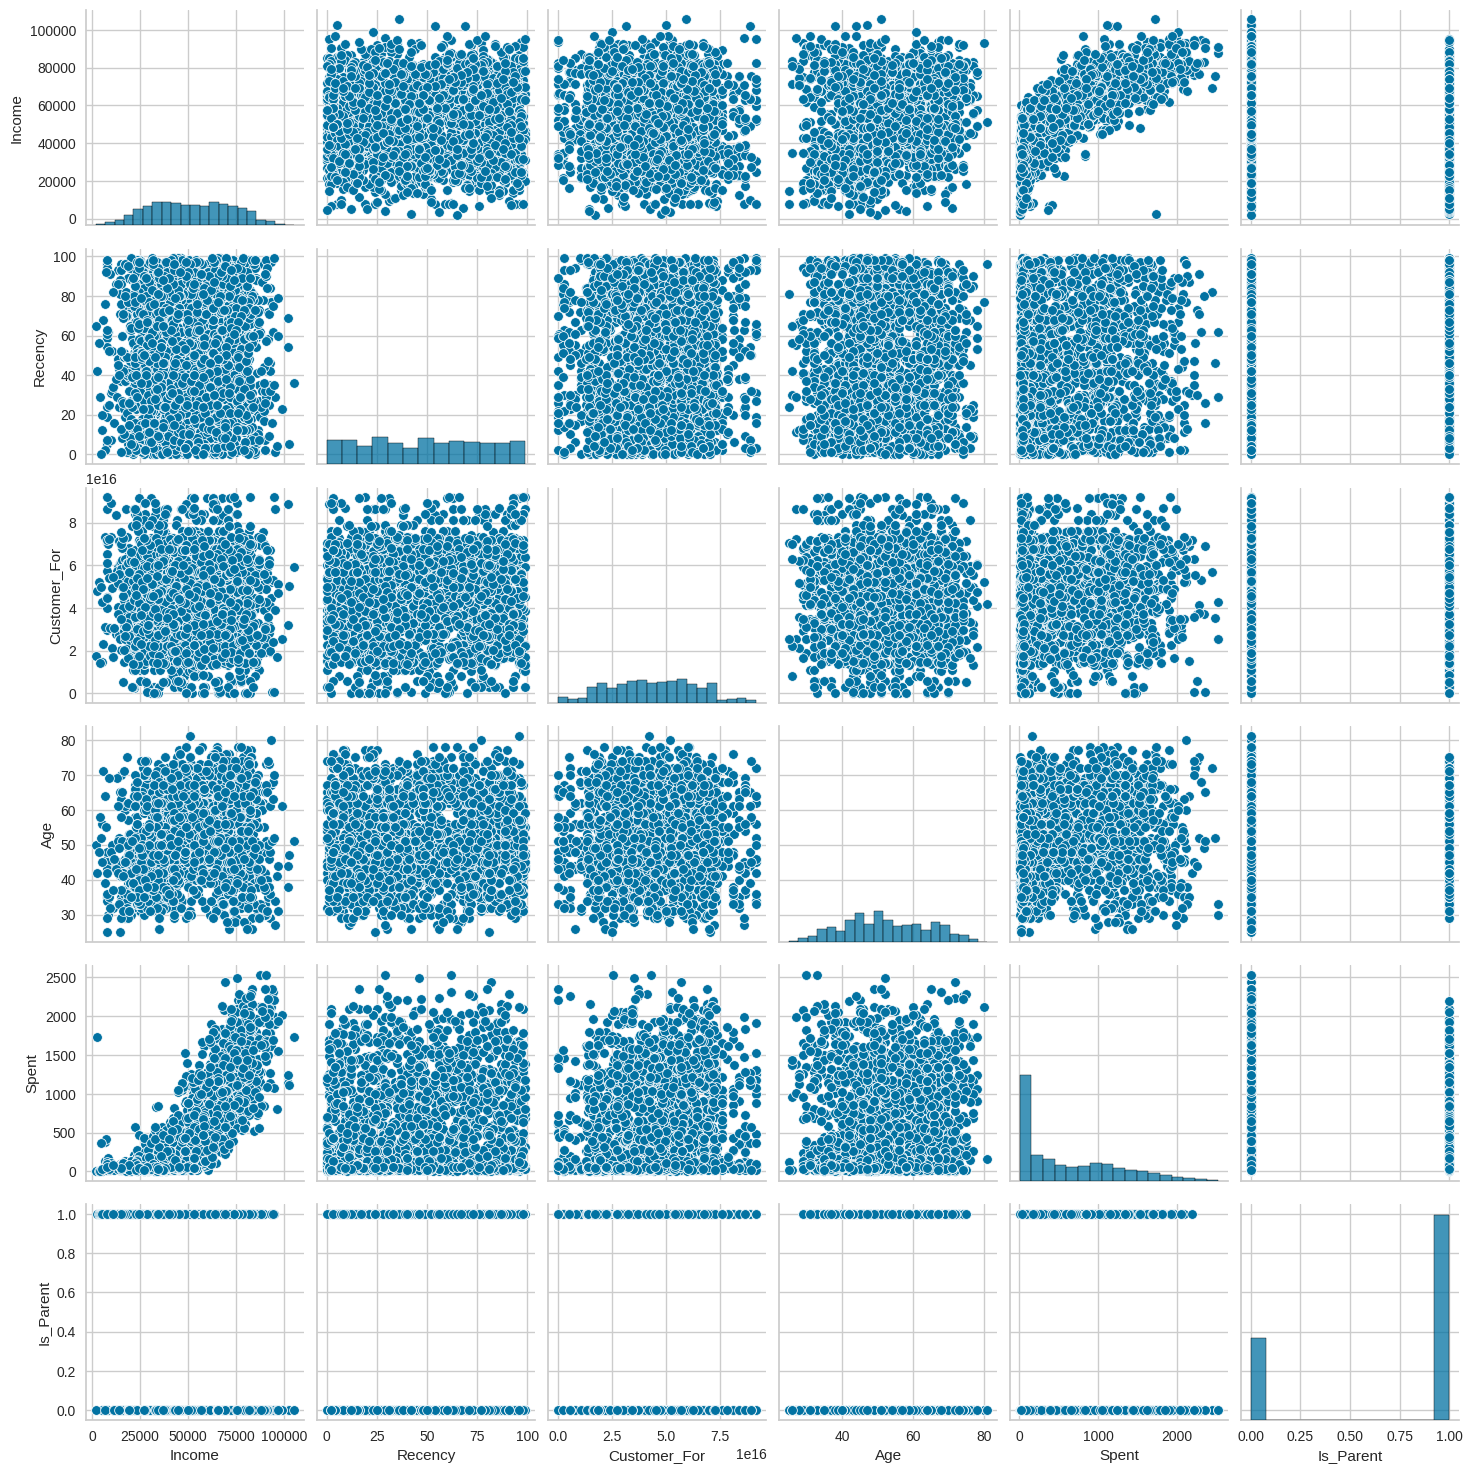

In [ ]:
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]

plt.figure()
sns.pairplot(data[To_Plot])

plt.show()

#Label Encoding

In [ ]:
#Creating a copy of data
ds = data.copy()
data1= data.copy()

In [ ]:
#Get list of categorical variables
s = (ds.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [ ]:
#Label Encoding the object dtypes.

LE=LabelEncoder()
for i in object_cols:
    ds[i]=ds[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [ ]:

# ds is the new dataset after dropping unnecessary feature
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2204 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2204 non-null   int64  
 1   Income               2204 non-null   float64
 2   Kidhome              2204 non-null   int64  
 3   Teenhome             2204 non-null   int64  
 4   Recency              2204 non-null   int64  
 5   Wines                2204 non-null   int64  
 6   Fruits               2204 non-null   int64  
 7   Meat                 2204 non-null   int64  
 8   Fish                 2204 non-null   int64  
 9   Sweets               2204 non-null   int64  
 10  Gold                 2204 non-null   int64  
 11  NumDealsPurchases    2204 non-null   int64  
 12  NumWebPurchases      2204 non-null   int64  
 13  NumCatalogPurchases  2204 non-null   int64  
 14  NumStorePurchases    2204 non-null   int64  
 15  NumWebVisitsMonth    2204 non-null   i

#Data Scaling

In [ ]:
print("Dataframe after scaling:")
scaled_ds.head()

Dataframe after scaling:


Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0  -0.891943  0.316587 -0.823719 -0.931161  0.310267  0.974116  1.548116   
1  -0.891943 -0.253978  1.038308  0.906152 -0.381307 -0.875138 -0.638853   
2  -0.891943  0.968474 -0.823719 -0.931161 -0.796251  0.354734  0.567751   
3  -0.891943 -1.206919  1.038308 -0.931161 -0.796251 -0.875138 -0.563440   
4   0.571826  0.324085  1.038308 -0.931161  1.555099 -0.395044  0.416926   

       Meat      Fish    Sweets  ...  NumCatalogPurchases  NumStorePurchases  \
0  1.747885  2.448544  1.493652  ...             2.628034          -0.563750   
1 -0.731943 -0.652568 -0.637399  ...            -0.588458          -1.181145   
2 -0.176277  1.335792 -0.147502  ...            -0.231070           1.288432   
3 -0.667651 -0.506633 -0.588410  ...            -0.945846          -0.563750   
4 -0.217608  0.150073 -0.000533  ...             0.126318           0.053644   

   NumWebVisitsMonth       Age     Spent  Living_With  Children  Family_Size  \
0           0.688736  1.018849  1.678808    -1.348486 -1.267338    -1.760647   
1          -0.140532  1.275375 -0.963993    -1.348486  1.403038     0.447928   
2          -0.555165  0.334780  0.280949     0.741572 -1.267338    -0.656360   
3           0.274102 -1.289886 -0.920778     0.741572  0.067850     0.447928   
4          -0.140532 -1.033359 -0.307448     0.741572  0.067850     0.447928   

   Is_Parent  Customer_For  
0  -1.585923      1.973904  
1   0.630548     -1.665920  
2  -1.585923     -0.172990  
3   0.630548     -1.924064  
4   0.630548     -0.822651  

[5 rows x 23 columns]

#Dimensionality Reduction (PCA)

In [ ]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["fea 1","fea 2", "fea 3"]))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
fea 1  2204.0 -6.447756e-18  2.905302 -6.048530 -2.571247 -0.786846  2.430601   
fea 2  2204.0  5.158205e-17  1.715925 -4.336611 -1.343208 -0.168201  1.240379   
fea 3  2204.0  2.417909e-17  1.223362 -3.573140 -0.837191 -0.026759  0.805546   

            max  
fea 1  7.518076  
fea 2  6.185347  
fea 3  6.733240

#Modeling

Determine the number of clusters (elbow method)

Elbow Method to determine the number of clusters to be formed:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

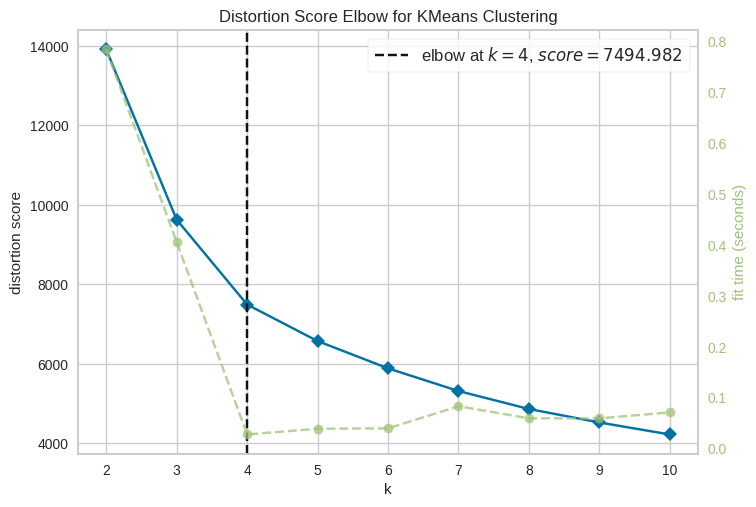

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# implement elbow method for recommendation of effective number of clusters
Elbow_M = KElbowVisualizer(AgglomerativeClustering(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

K-means

In [ ]:
#Model Initiating (K-means)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(PCA_ds)

PCA_ds["Clusters"] = kmeans.labels_

data["Clusters"] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


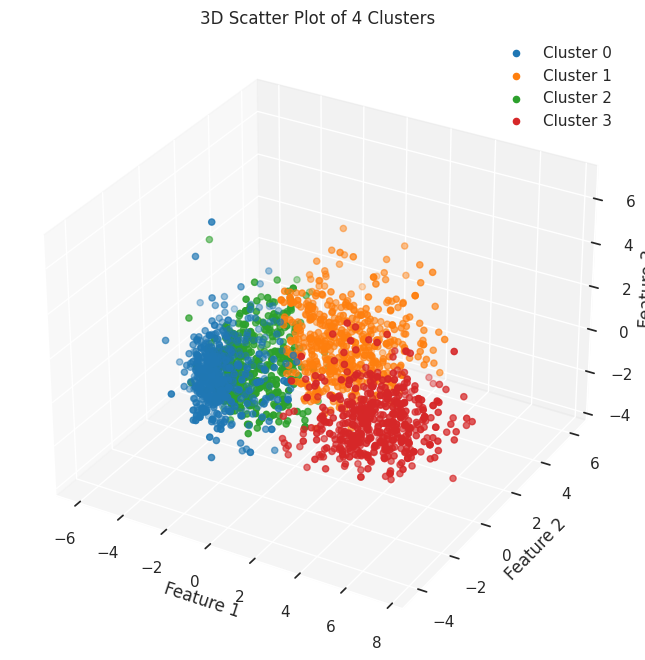

In [ ]:
# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plotting data points based on their clusters
for cluster_label, color in zip(range(4), colors):
    cluster_data = PCA_ds[PCA_ds['Clusters'] == cluster_label]
    ax.scatter(cluster_data['col1'], cluster_data['col2'], cluster_data['col3'], c=color, label=f'Cluster {cluster_label}')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of 4 Clusters')
ax.legend()
plt.show()

model evaluation

Silhouette Score: Measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Silhouette scores range from -1 to 1, where a high value indicates well-defined clusters.

Calinski-Harabasz Index: Calculates the ratio of the sum of between-cluster dispersion to within-cluster dispersion. Higher values indicate better-defined clusters.

Davies-Bouldin Index: Measures the average similarity ratio of each cluster with the cluster that is most similar to it. Lower values indicate better clustering.

Within-Cluster Sum of Squares (WCSS): Represents the sum of squared distances between data points and their assigned cluster centroids. Lower WCSS values indicate better clustering, as it means the data points are closer to their cluster centroids.

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Calculate Silhouette Score
silhouette_avg = silhouette_score(PCA_ds,  kmeans.labels_)

# Calculate Calinski-Harabasz Index
ch_score = calinski_harabasz_score(PCA_ds,  kmeans.labels_)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(PCA_ds, kmeans.labels_)

# Calculate WCSS
wcss = kmeans.inertia_

print("silhouette score: ", silhouette_avg)
print("Calinski-Harabasz Index: ", ch_score)
print("Davies-Bouldin Index: ", db_index)
print("Within-Cluster Sum of Squares (WCSS): ", wcss)

silhouette score:  0.4456622976250932
Calinski-Harabasz Index:  2313.545504385949
Davies-Bouldin Index:  0.8572266176271933
Within-Cluster Sum of Squares (WCSS):  7495.036594959798


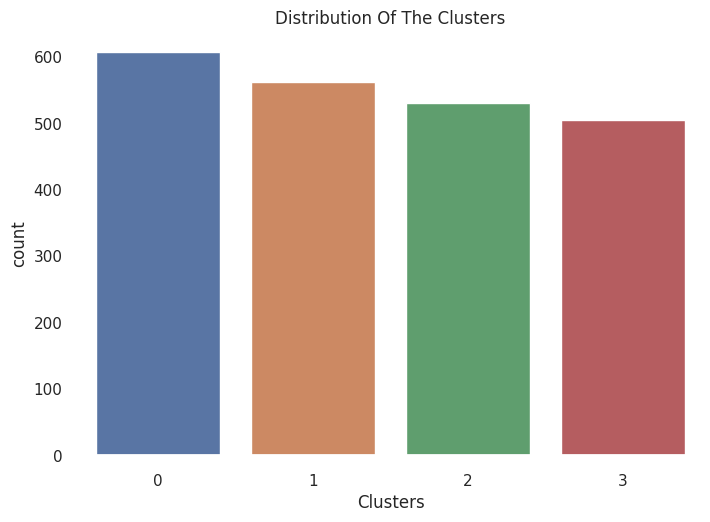

In [ ]:
#Plotting countplot of clusters

pl = sns.countplot(x=data["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

#Clustering Analysis

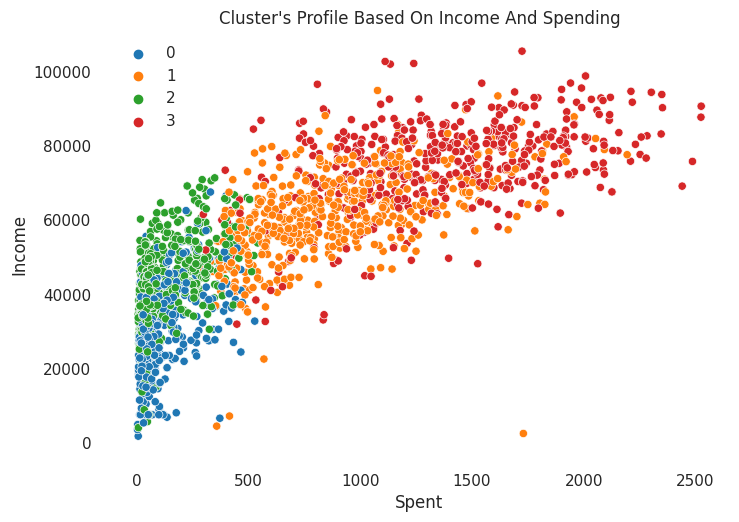

In [ ]:
pal = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728"]
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

cluster 0: low income, low spending

cluster 1: average income, average spending

cluster 2: average income, low spending

cluster 3: high income, from average to high spending

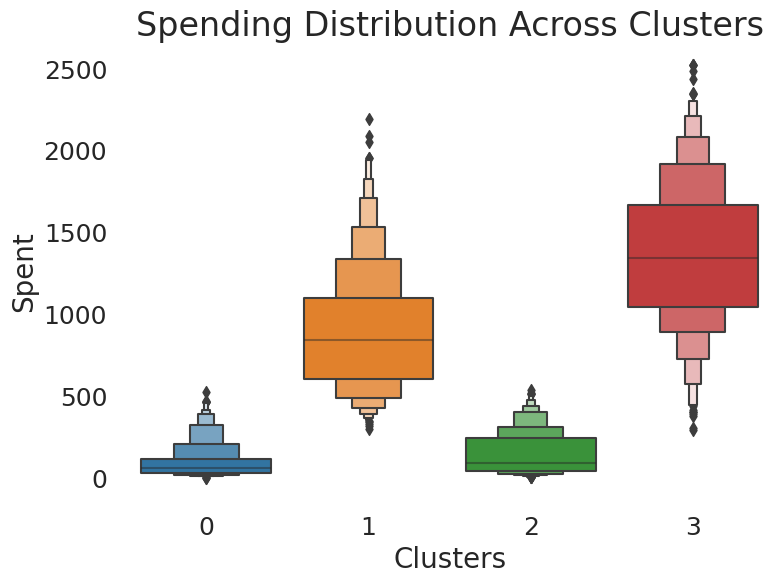

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Create the boxenplot
pl = sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.title('Spending Distribution Across Clusters', fontsize=24)
plt.xlabel('Clusters', fontsize=20)
plt.ylabel('Spent', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()


Low spending: cluster 0 and cluster 2

Average spending: cluster 1

High spending: cluster 3

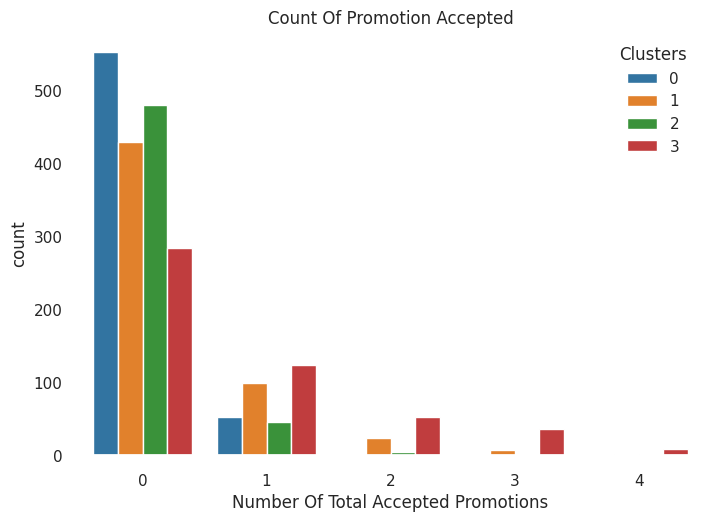

In [ ]:
#Creating a feature to get a sum of accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

In terms of the five promotion types, AcceptedCmp1 stands out as the most preferred choice among customers. Additionally, the utilization of different promotion types is more diverse within group 3 customers.

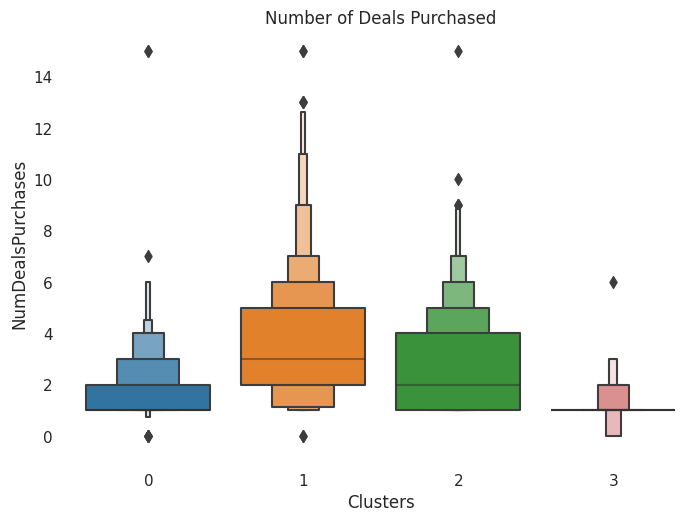

In [ ]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

The number of purchases with discounts made by customers is quite low among all groups, mainly ranging from 1 to 5 purchases per customer, especially low for group 3, which makes barely any purchases with discounts.

#Profiling

<Figure size 800x550 with 0 Axes>

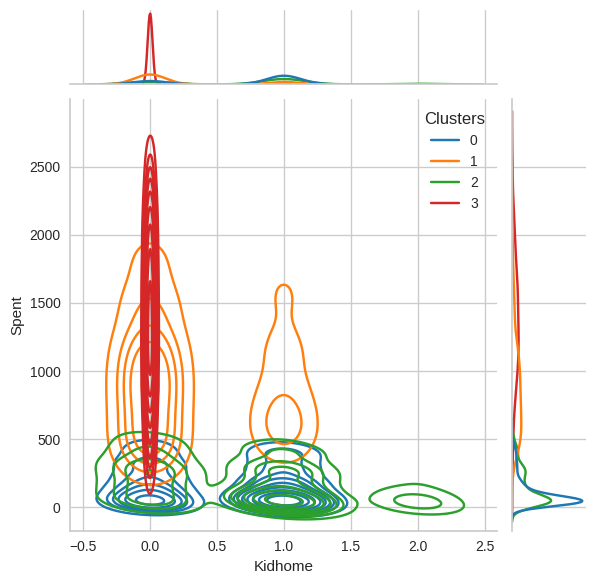

<Figure size 800x550 with 0 Axes>

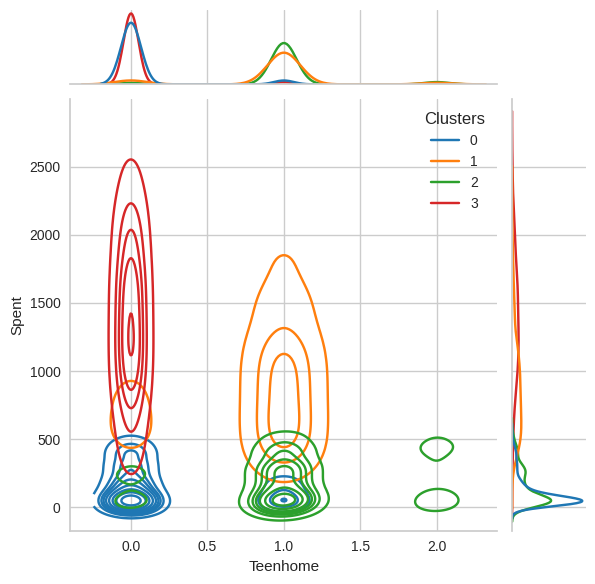

<Figure size 800x550 with 0 Axes>

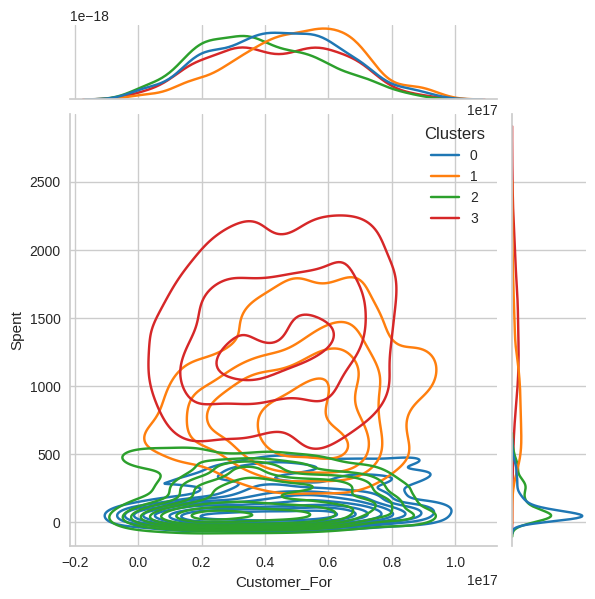

<Figure size 800x550 with 0 Axes>

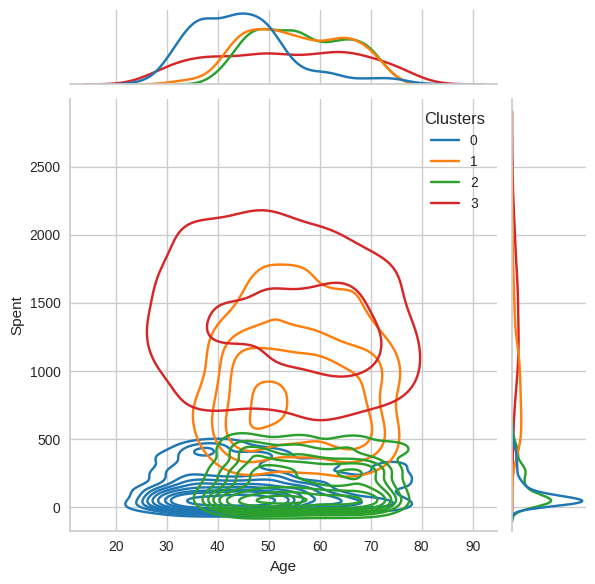

<Figure size 800x550 with 0 Axes>

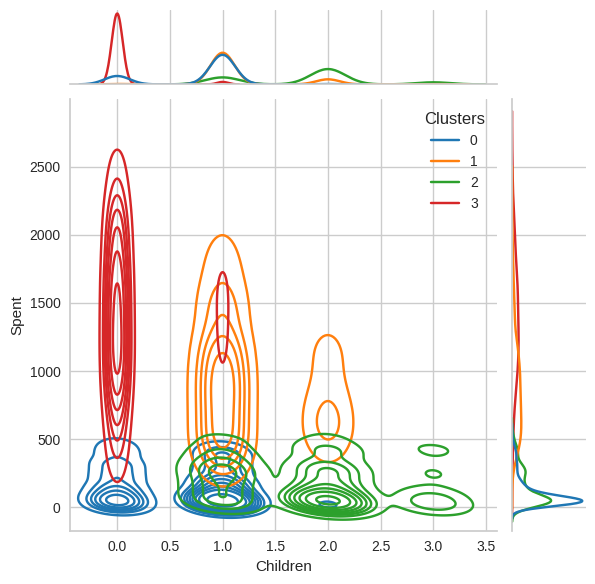

<Figure size 800x550 with 0 Axes>

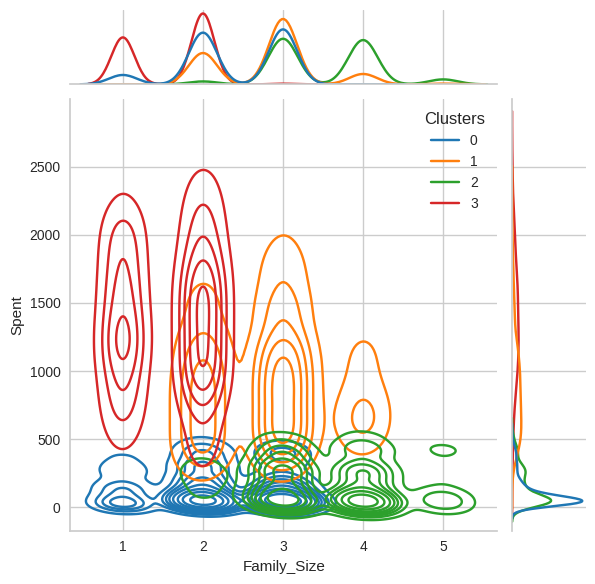

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

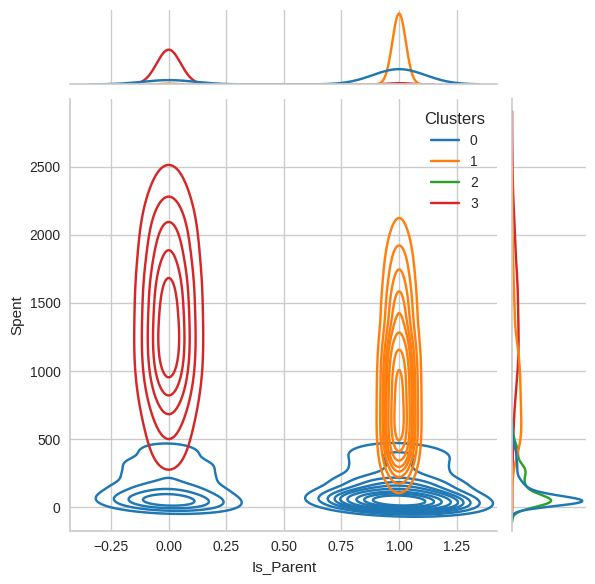

<Figure size 800x550 with 0 Axes>

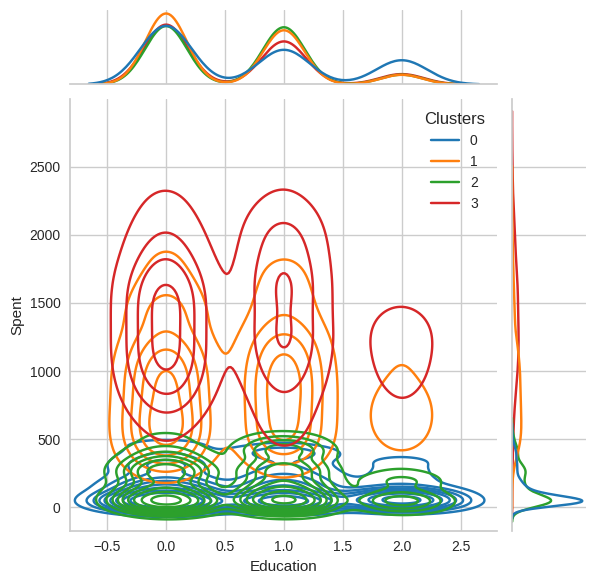

<Figure size 800x550 with 0 Axes>

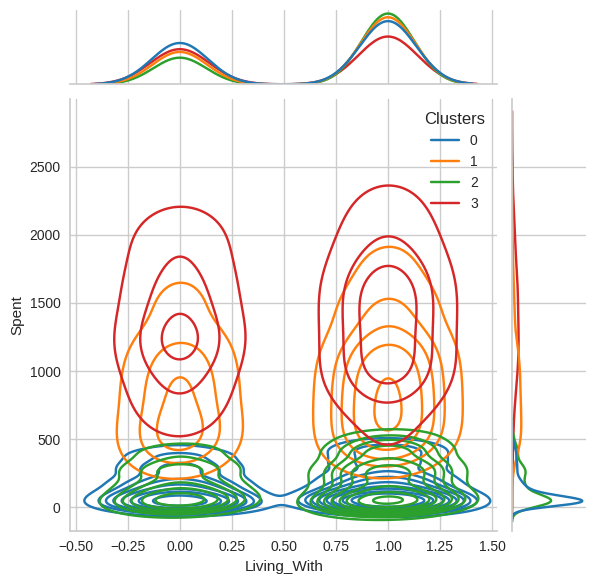

In [ ]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]
pal = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728"]
for i in Personal:
    plt.figure()
    sns.jointplot(x=ds[i], y=ds["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()

Cluster 0:

- The majority of these people are parents
- At the max are 3 members in the family
- They majorly have one kid and not teenagers
- Relatively younger

Cluster 1:

- Are definitely a parent

- At the max have 4 members in the family and at least 2

- Most have teenager at home
- Relatively older


Cluster 2
- Definitely a parent
- At the max of 5 members and at least 3 in the family
- Majority have teenager
- Relatively older

Cluster 3
- Are definitely not a parent
- At the max of 2 people in the family
- All ages


#Apendix

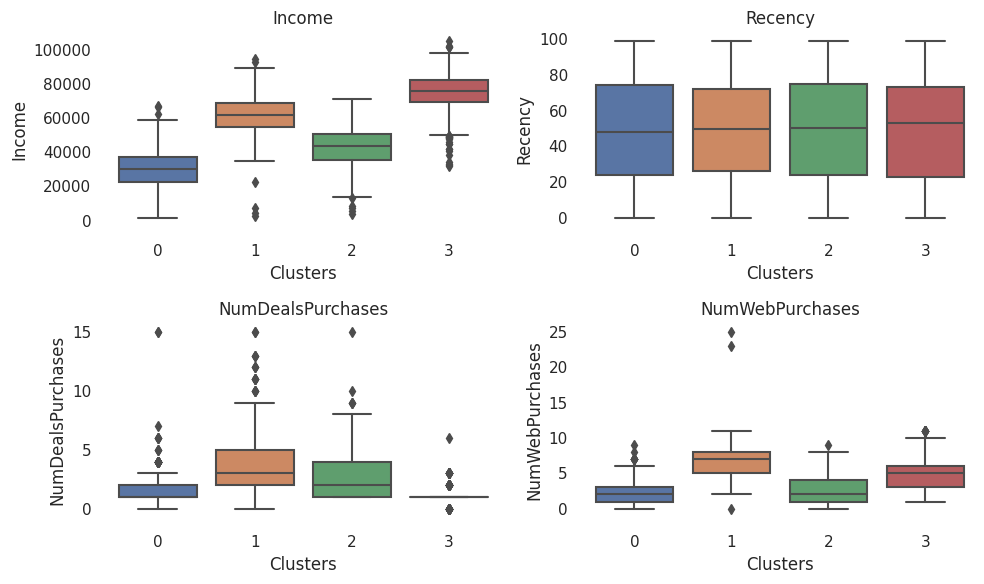

In [ ]:
plt.figure(figsize=(10, 6))
for i, feature in enumerate(['Income', 'Recency', 'NumDealsPurchases', 'NumWebPurchases']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Clusters', y=feature, data=data)
    plt.title(feature)
plt.tight_layout()
plt.show()

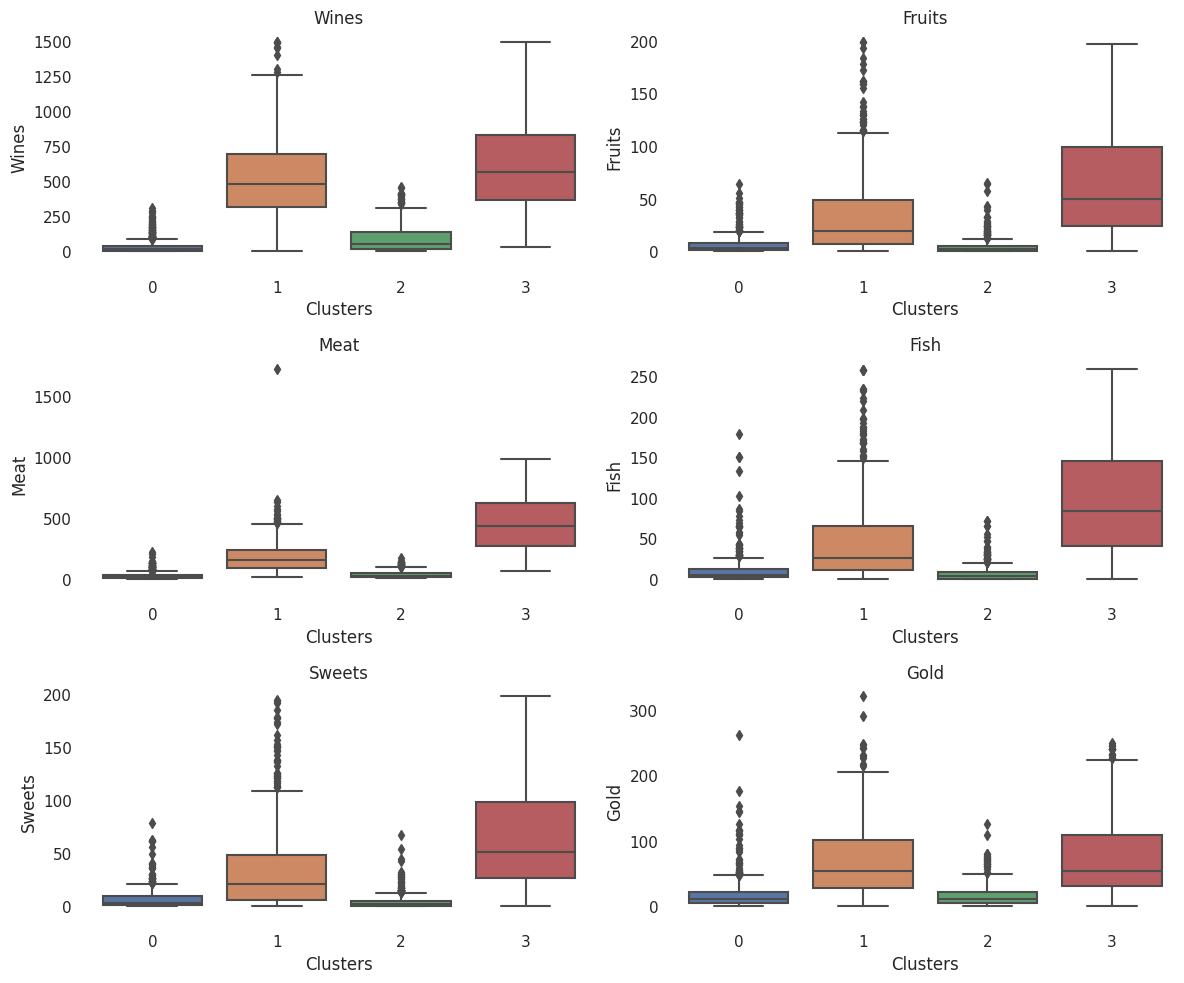

In [ ]:
plt.figure(figsize=(12, 10))
for i, feature in enumerate(['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x='Clusters', y=feature, data=data)
    plt.title(feature)
plt.tight_layout()
plt.show()

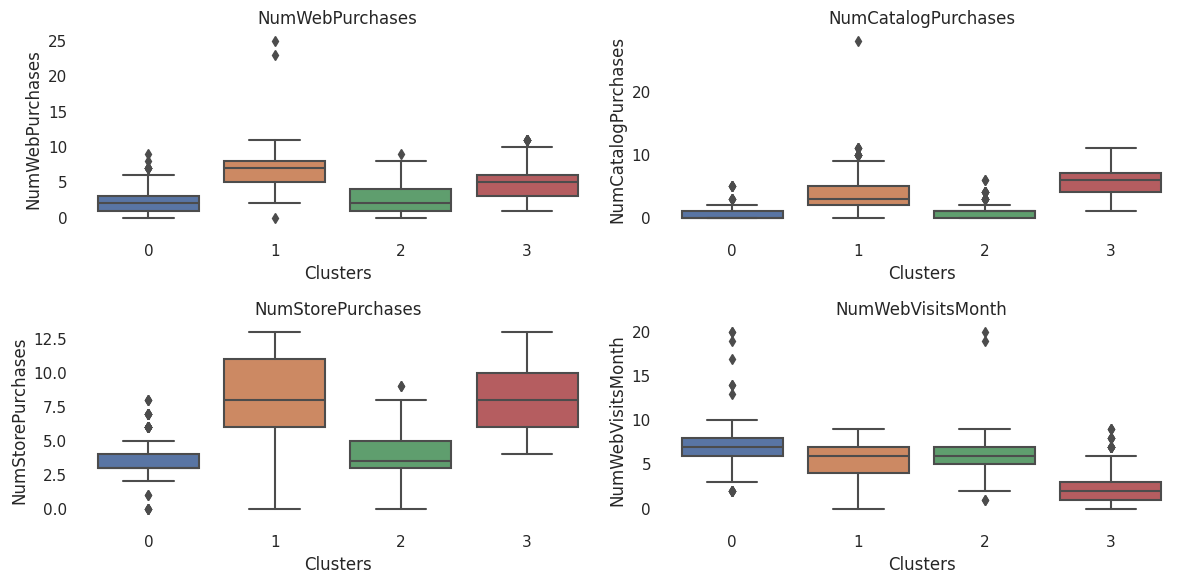

In [ ]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate([ 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Clusters', y=feature, data=data)
    plt.title(feature)
plt.tight_layout()
plt.show()

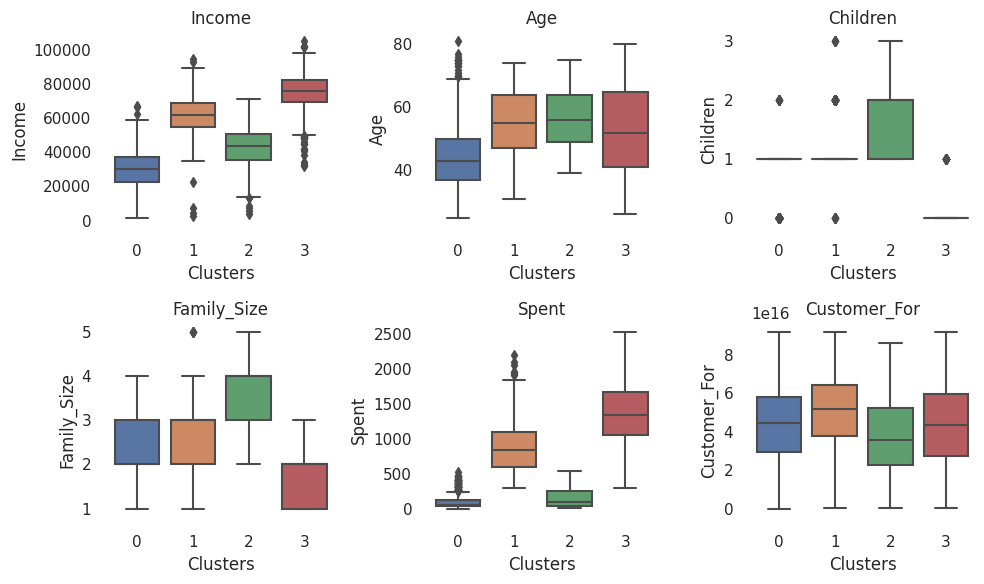

In [ ]:
plt.figure(figsize=(10, 6))
for i, feature in enumerate([ 'Income', 'Age', 'Children', 'Family_Size','Spent','Customer_For']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Clusters', y=feature, data=data)
    plt.title(feature)
plt.tight_layout()
plt.show()

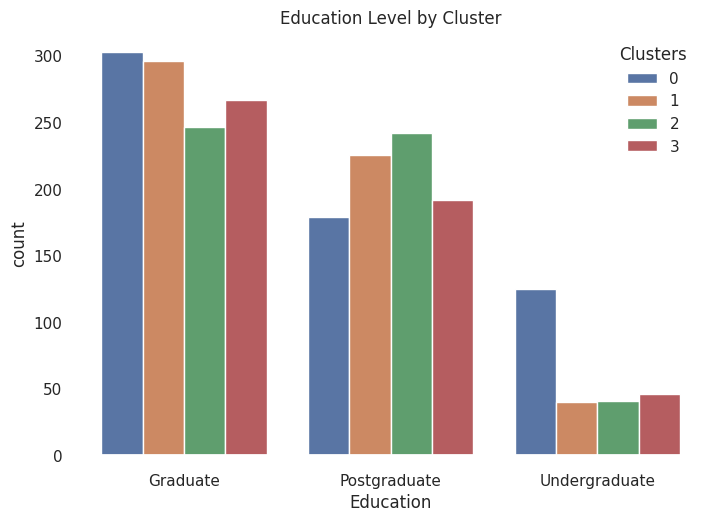

In [ ]:
sns.countplot(x='Education', hue='Clusters', data=data)
plt.title('Education Level by Cluster')
plt.show()


In [ ]:
# Define the feature for which you want to use describe() for each cluster
feature_name = 'Income'

# Iterate through unique cluster labels and apply describe() to the specified feature
for cluster_label in data['Clusters'].unique():
    cluster_data = data[data['Clusters'] == cluster_label]
    feature_description = cluster_data[feature_name].describe()

    print(f"Cluster {cluster_label} - {feature_name} Description:")

Cluster 3 - Income Description:
Cluster 2 - Income Description:
Cluster 0 - Income Description:
Cluster 1 - Income Description:


In [ ]:

# Define the features for which you want to compute statistics
feature_names = [ 'Income']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Income                                                          \
          count          mean           std      min       25%      50%   
Clusters                                                                  
0         607.0  29985.313015  10770.783734   1730.0  22609.50  30023.0   
1         562.0  61686.478648  11326.006325   2447.0  55218.75  62059.5   
2         530.0  43018.313208  11597.258197   4023.0  35791.00  43534.0   
3         505.0  75335.431683  11269.817732  31907.0  69520.00  76140.0   

                              
               75%       max  
Clusters                      
0         37398.00   67506.0  
1         69078.75   94871.0  
2         50773.00   71322.0  
3         82427.00  105471.0  


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Age']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

            Age                                                     
          count       mean        std   min   25%   50%    75%   max
Clusters                                                            
0         607.0  44.574959   9.808424  25.0  37.0  43.0  50.00  81.0
1         562.0  55.318505   9.643372  31.0  47.0  55.0  63.75  74.0
2         530.0  56.456604   8.901849  39.0  49.0  56.0  64.00  75.0
3         505.0  52.924752  13.976109  26.0  41.0  52.0  65.00  80.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Recency']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Recency                                                   
           count       mean        std  min   25%   50%   75%   max
Clusters                                                           
0          607.0  48.594728  28.727475  0.0  24.0  48.0  74.5  99.0
1          562.0  49.000000  28.532435  0.0  26.0  49.5  72.0  99.0
2          530.0  49.158491  29.203111  0.0  24.0  50.0  75.0  99.0
3          505.0  49.439604  29.382548  0.0  23.0  53.0  73.0  99.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'NumDealsPurchases']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         NumDealsPurchases                                              
                     count      mean       std  min  25%  50%  75%   max
Clusters                                                                
0                    607.0  1.800659  1.269651  0.0  1.0  1.0  2.0  15.0
1                    562.0  3.597865  2.329810  0.0  2.0  3.0  5.0  15.0
2                    530.0  2.754717  1.790604  1.0  1.0  2.0  4.0  15.0
3                    505.0  1.063366  0.523216  0.0  1.0  1.0  1.0   6.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'NumWebPurchases']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         NumWebPurchases                                              
                   count      mean       std  min  25%  50%  75%   max
Clusters                                                              
0                  607.0  2.210873  1.450508  0.0  1.0  2.0  3.0   9.0
1                  562.0  6.640569  2.549823  0.0  5.0  7.0  8.0  25.0
2                  530.0  2.683019  1.750370  0.0  1.0  2.0  4.0   9.0
3                  505.0  4.988119  2.085441  1.0  3.0  5.0  6.0  11.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'NumCatalogPurchases']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         NumCatalogPurchases                                              
                       count      mean       std  min  25%  50%  75%   max
Clusters                                                                  
0                      607.0  0.527183  0.765706  0.0  0.0  0.0  1.0   5.0
1                      562.0  3.766904  2.412262  0.0  2.0  3.0  5.0  28.0
2                      530.0  0.833962  0.909297  0.0  0.0  1.0  1.0   6.0
3                      505.0  5.849505  2.375705  1.0  4.0  6.0  7.0  11.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'NumStorePurchases']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         NumStorePurchases                                               
                     count      mean       std  min  25%  50%   75%   max
Clusters                                                                 
0                    607.0  3.171334  1.115582  0.0  3.0  3.0   4.0   8.0
1                    562.0  8.316726  2.763275  0.0  6.0  8.0  11.0  13.0
2                    530.0  3.824528  1.471006  0.0  3.0  3.5   5.0   9.0
3                    505.0  8.346535  2.763982  4.0  6.0  8.0  10.0  13.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'NumWebVisitsMonth']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         NumWebVisitsMonth                                              
                     count      mean       std  min  25%  50%  75%   max
Clusters                                                                
0                    607.0  6.815486  1.932583  2.0  6.0  7.0  8.0  20.0
1                    562.0  5.498221  1.891202  0.0  4.0  6.0  7.0   9.0
2                    530.0  6.013208  1.877590  1.0  5.0  6.0  7.0  20.0
3                    505.0  2.679208  1.744624  0.0  1.0  2.0  3.0   9.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Spent']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

          Spent                                                            \
          count         mean         std    min      25%     50%      75%   
Clusters                                                                    
0         607.0   101.945634  102.378151    5.0    37.00    63.0   122.50   
1         562.0   893.930605  368.022640  302.0   605.25   844.5  1105.25   
2         530.0   150.766038  130.438993    8.0    45.00    94.0   249.25   
3         505.0  1373.443564  441.760881  299.0  1049.00  1348.0  1672.00   

                  
             max  
Clusters          
0          529.0  
1         2194.0  
2          542.0  
3         2525.0  


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Children']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Children                                             
            count      mean       std  min  25%  50%  75%  max
Clusters                                                      
0           607.0  0.790774  0.430726  0.0  1.0  1.0  1.0  2.0
1           562.0  1.142349  0.401894  0.0  1.0  1.0  1.0  3.0
2           530.0  1.798113  0.575817  1.0  1.0  2.0  2.0  3.0
3           505.0  0.033663  0.180540  0.0  0.0  0.0  0.0  1.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Family_Size']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Family_Size                                             
               count      mean       std  min  25%  50%  75%  max
Clusters                                                         
0              607.0  2.395387  0.635977  1.0  2.0  2.0  3.0  4.0
1              562.0  2.816726  0.623547  1.0  2.0  3.0  3.0  5.0
2              530.0  3.524528  0.642215  2.0  3.0  4.0  4.0  5.0
3              505.0  1.609901  0.500299  1.0  1.0  2.0  2.0  3.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Customer_For']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Customer_For                                                          \
                count          mean           std           min           25%   
Clusters                                                                        
0               607.0  4.402144e+16  1.999283e+16  0.000000e+00  2.954880e+16   
1               562.0  5.067145e+16  1.889861e+16  8.640000e+13  3.795120e+16   
2               530.0  3.833666e+16  1.943261e+16  8.640000e+13  2.255040e+16   
3               505.0  4.360531e+16  2.014462e+16  8.640000e+13  2.756160e+16   

                                                    
                   50%           75%           max  
Clusters                                            
0         4.432320e+16  5.832000e+16  9.184320e+16  
1         5.205600e+16  6.434640e+16  9.184320e+16  
2         3.589920e+16  5.253120e+16  8.640000e+16  
3         4.363200e+16  5.944320e+16  9.184320e+16  


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Kidhome']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Kidhome                                             
           count      mean       std  min  25%  50%  75%  max
Clusters                                                     
0          607.0  0.731466  0.461789  0.0  0.0  1.0  1.0  2.0
1          562.0  0.204626  0.412522  0.0  0.0  0.0  0.0  2.0
2          530.0  0.781132  0.564567  0.0  0.0  1.0  1.0  2.0
3          505.0  0.003960  0.062869  0.0  0.0  0.0  0.0  1.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Teenhome']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Teenhome                                             
            count      mean       std  min  25%  50%  75%  max
Clusters                                                      
0           607.0  0.059308  0.236395  0.0  0.0  0.0  0.0  1.0
1           562.0  0.937722  0.379559  0.0  1.0  1.0  1.0  2.0
2           530.0  1.016981  0.291165  0.0  1.0  1.0  1.0  2.0
3           505.0  0.029703  0.169935  0.0  0.0  0.0  0.0  1.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Wines']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

          Wines                                                            
          count        mean         std   min     25%    50%    75%     max
Clusters                                                                   
0         607.0   34.546952   51.104055   0.0    5.00   14.0   38.0   308.0
1         562.0  529.537367  295.407304   1.0  312.25  479.5  691.0  1492.0
2         530.0   90.052830   95.980115   1.0   19.25   51.0  137.5   456.0
3         505.0  611.463366  317.767434  33.0  362.00  565.0  829.0  1493.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Fruits']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Fruits                                                    
          count       mean        std  min   25%   50%   75%    max
Clusters                                                           
0         607.0   6.579901   9.207175  0.0   1.0   3.0   8.0   64.0
1         562.0  33.935943  38.583236  0.0   7.0  19.0  49.0  199.0
2         530.0   4.409434   7.681780  0.0   0.0   2.0   5.0   65.0
3         505.0  64.978218  50.629544  0.0  24.0  50.0  99.0  197.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Meat']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

           Meat                                                            
          count        mean         std   min     25%    50%    75%     max
Clusters                                                                   
0         607.0   25.719934   30.013484   0.0    8.00   15.0   29.0   217.0
1         562.0  179.309609  133.664545  12.0   90.25  151.0  235.0  1725.0
2         530.0   30.324528   29.935222   1.0    9.00   19.0   43.0   171.0
3         505.0  459.512871  236.380226  64.0  267.00  430.0  625.0   984.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Fish']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

           Fish                                                      
          count       mean        std  min   25%   50%     75%    max
Clusters                                                             
0         607.0  10.184514  17.278315  0.0   2.0   4.0   12.00  179.0
1         562.0  44.651246  50.520176  0.0  10.0  25.0   64.75  258.0
2         530.0   6.081132   9.772218  0.0   0.0   3.0    7.75   71.0
3         505.0  96.540594  65.994249  0.0  40.0  84.0  146.00  259.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Sweets']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Sweets                                                     
          count       mean        std  min   25%   50%    75%    max
Clusters                                                            
0         607.0   6.726524   9.368563  0.0   1.0   3.0   9.00   78.0
1         562.0  35.298932  40.869947  0.0   6.0  21.0  47.75  195.0
2         530.0   4.269811   7.023915  0.0   0.0   2.0   5.00   67.0
3         505.0  66.083168  51.246187  0.0  26.0  51.0  98.00  198.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Gold']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

           Gold                                                      
          count       mean        std  min   25%   50%     75%    max
Clusters                                                             
0         607.0  18.187809  24.063125  0.0   5.0  11.0   22.00  262.0
1         562.0  71.197509  56.651247  0.0  28.0  54.0  100.75  321.0
2         530.0  15.628302  16.840392  0.0   4.0  10.0   22.00  125.0
3         505.0  74.865347  60.886259  0.0  30.0  53.0  108.00  249.0


In [ ]:
data

Education   Income  Kidhome  Teenhome  Recency  Wines  Fruits  Meat  \
0         Graduate  58138.0        0         0       58    635      88   546   
1         Graduate  46344.0        1         1       38     11       1     6   
2         Graduate  71613.0        0         0       26    426      49   127   
3         Graduate  26646.0        1         0       26     11       4    20   
4     Postgraduate  58293.0        1         0       94    173      43   118   
...            ...      ...      ...       ...      ...    ...     ...   ...   
2235      Graduate  61223.0        0         1       46    709      43   182   
2236  Postgraduate  64014.0        2         1       56    406       0    30   
2237      Graduate  56981.0        0         0       91    908      48   217   
2238  Postgraduate  69245.0        0         1        8    428      30   214   
2239  Postgraduate  52869.0        1         1       40     84       3    61   

      Fish  Sweets  ...  Response  Age  Spent  Living_With  Children  \
0      172      88  ...         1   64   1617        Alone         0   
1        2       1  ...         0   67     27        Alone         2   
2      111      21  ...         0   56    776      Partner         0   
3       10       3  ...         0   37     53      Partner         1   
4       46      27  ...         0   40    422      Partner         1   
...    ...     ...  ...       ...  ...    ...          ...       ...   
2235    42     118  ...         0   54   1341      Partner         1   
2236     0       0  ...         0   75    444      Partner         3   
2237    32      12  ...         0   40   1241        Alone         0   
2238    80      30  ...         0   65    843      Partner         1   
2239     2       1  ...         1   67    172      Partner         2   

      Family_Size  Is_Parent       Customer_For  Clusters  Total_Promos  
0               1          0  83894400000000000         3             0  
1               3          1  10800000000000000         2             0  
2               2          0  40780800000000000         3             0  
3               3          1   5616000000000000         0             0  
4               3          1  27734400000000000         2             0  
...           ...        ...                ...       ...           ...  
2235            3          1  46742400000000000         1             0  
2236            5          1   5270400000000000         2             1  
2237            1          0  27216000000000000         3             1  
2238            3          1  27302400000000000         1             0  
2239            4          1  67564800000000000         2             0  

[2204 rows x 32 columns]